In [50]:
import os
import os.path
import pickle
import theano
import theano.tensor as T
import lasagne
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

def loaddata(file):
    with open(file, 'rb') as inFile:
        states, actions, rewards = pickle.load(inFile)
    
    # states to numpy array between 0 and 1
    states = np.asarray(states[0], dtype=theano.config.floatX)
    states /= np.max(states)
    states = np.swapaxes(np.swapaxes(states,1,3), 2,3)
    
    # actions to one_hot vector 
    actions = np.asarray(actions[0])
    actionInds = np.unique(actions)
#     print(actionInds)
    # using hinge loss data must be -1 or 1
    one_hot = -1 * np.ones((actions.shape[0], actionInds.size), dtype=theano.config.floatX)
    # for loop because it's easy
    for ind in range(actions.shape[0]):
        actionRow = actions[ind]
        actionInd = np.where(actionRow == actionInds)
        one_hot[ind, actionInd] = 1
    
    return states, one_hot

X = np.empty((0,3,86,80), dtype=theano.config.floatX)
Y = np.empty((0, 6), dtype=theano.config.floatX)
for dirs in os.listdir():
    if os.path.isfile(dirs):
        if 'dataset' in dirs and 'spc' in dirs:
            st = time.time()
            s, a = loaddata(dirs)
            et = time.time()
            print(dirs, s.shape, a.shape, et-st)
            X = np.vstack((X, s))
            Y = np.vstack((Y, a))

spc_inv_dataset1a.pkl (1583, 3, 86, 80) (1583, 6) 0.1401360034942627
spc_inv_dataset1b.pkl (909, 3, 86, 80) (909, 6) 0.06305718421936035
spc_inv_dataset1c.pkl (1276, 3, 86, 80) (1276, 6) 0.11711382865905762
spc_inv_dataset1d.pkl (3432, 3, 86, 80) (3432, 6) 0.21420502662658691
spc_inv_dataset1e.pkl (2822, 3, 86, 80) (2822, 6) 0.19518804550170898
spc_inv_dataset1f.pkl (1572, 3, 86, 80) (1572, 6) 0.12311911582946777
spc_inv_dataset1g.pkl (956, 3, 86, 80) (956, 6) 0.07407093048095703
spc_inv_dataset1h.pkl (2762, 3, 86, 80) (2762, 6) 0.18317890167236328
spc_inv_dataset1i.pkl (1449, 3, 86, 80) (1449, 6) 0.11510801315307617
spc_inv_dataset1j.pkl (2226, 3, 86, 80) (2226, 6) 0.15913891792297363
spc_inv_dataset1k.pkl (1491, 3, 86, 80) (1491, 6) 0.11813116073608398
spc_inv_dataset1l.pkl (1493, 3, 86, 80) (1493, 6) 0.11611080169677734
spc_inv_dataset1m.pkl (1128, 3, 86, 80) (1128, 6) 0.09709382057189941
spc_inv_dataset1n.pkl (2168, 3, 86, 80) (2168, 6) 0.15815186500549316
spc_inv_dataset1o.pkl (82

In [51]:
print(X.shape, X.dtype, np.max(X), np.min(X))
print(Y.shape, Y.dtype, np.max(Y), np.min(Y))
# truth must be -1 and 1
assert(np.min(Y) == -1)

(30765, 3, 86, 80) float32 1.0 0.0
(30765, 6) float32 1.0 -1.0


In [80]:
# define the network
from lasagne.regularization import regularize_network_params, l2
clip = 1
l_in = lasagne.layers.InputLayer((None,)+X.shape[1:])

l_hid1 = lasagne.layers.Conv2DLayer(l_in, 16, (8, 8), stride=4, untie_biases=True)
l_pool1 = lasagne.layers.MaxPool2DLayer(l_hid1, 2)

l_hid2 = lasagne.layers.Conv2DLayer(l_pool1, 32, (4, 4), stride=2, untie_biases=True)
l_pool2 = lasagne.layers.MaxPool2DLayer(l_hid2, 2)

l_hid3 = lasagne.layers.DenseLayer(l_pool2, 256)
l_out = lasagne.layers.DenseLayer(l_hid3, Y.shape[1], nonlinearity=lasagne.nonlinearities.linear)

net_output = lasagne.layers.get_output(l_out)
reg = regularize_network_params(l_out, l2)
truth = T.matrix()
loss = T.mean(T.maximum(0, 1-(truth * net_output))**2) + reg*0.001

params = lasagne.layers.get_all_params(l_out)
grads = lasagne.updates.total_norm_constraint(T.grad(loss, params), clip)
update = lasagne.updates.rmsprop(grads, params, 0.002)

train = theano.function([l_in.input_var, truth], loss, updates=update)
get_output = theano.function([l_in.input_var], outputs=net_output)
get_hid1_act = theano.function([l_in.input_var], outputs=lasagne.layers.get_output(l_hid1))
get_hid2_act = theano.function([l_in.input_var], outputs=lasagne.layers.get_output(l_hid2))

In [99]:
def flipActions(actions):
    threes = np.where(actions[:,2] == 1)    
    fours = np.where(actions[:,3] == 1)
    elevens = np.where(actions[:,4] == 1)
    twelves = np.where(actions[:,5] == 1)
    actions[threes, :] = -1
    actions[threes, 3] = 1    
    actions[fours, :] = -1    
    actions[fours, 2] = 1
    actions[elevens, :] = -1    
    actions[elevens, 5] = 1
    actions[twelves, :] = -1    
    actions[twelves, 4] = 1
    return actions
import copy

batchSize = 36
mbs = int(np.floor(X.shape[0]/batchSize))
for ep in range(10):
    rp = np.random.permutation(X.shape[0])
    for mb in range(mbs):
        mbInd = rp[batchSize*mb:batchSize*mb+batchSize]
        
        # rand fliping
#         if np.random.random() < 0.5:
#             flipX = X[mbInd,:,:,::-1]
#             flipY = flipActions(copy.deepcopy(Y[mbInd]))            
#             cost = train(flipX, flipY)
#         else:
        cost = train(X[mbInd], Y[mbInd])
        
        if mb % 100 == 0:
            print('{0}/{1} cost:'.format(mb, mbs), cost)

0/854 cost: 0.37371885776519775
100/854 cost: 0.38601985573768616
200/854 cost: 0.31104838848114014
300/854 cost: 0.36041030287742615
400/854 cost: 0.422100305557251
500/854 cost: 0.3054100573062897
600/854 cost: 0.3722781538963318
700/854 cost: 0.3194456100463867
800/854 cost: 0.4595445692539215
0/854 cost: 0.4235610365867615
100/854 cost: 0.36477896571159363
200/854 cost: 0.4396417438983917
300/854 cost: 0.38509154319763184
400/854 cost: 0.3010590076446533
500/854 cost: 0.41129928827285767
600/854 cost: 0.33103129267692566
700/854 cost: 0.44796738028526306
800/854 cost: 0.36640968918800354
0/854 cost: 0.3504285514354706
100/854 cost: 0.3858686089515686
200/854 cost: 0.37160179018974304
300/854 cost: 0.36685124039649963
400/854 cost: 0.3374900221824646
500/854 cost: 0.44647639989852905
600/854 cost: 0.3597990870475769
700/854 cost: 0.3560880124568939
800/854 cost: 0.32332220673561096
0/854 cost: 0.327944815158844
100/854 cost: 0.40749096870422363
200/854 cost: 0.38430356979370117
300/

In [100]:
def swapaxes(x):
    return np.swapaxes(np.swapaxes(x,0,2),0,1)

In [101]:
h1 = get_hid1_act(X[0:5000])
pred = get_output(X[0:5000])
print(np.where(np.argmax(pred, axis=1)!=0))

(array([  75,   76,   81, ..., 4997, 4998, 4999], dtype=int64),)


(5000, 16, 20, 19)


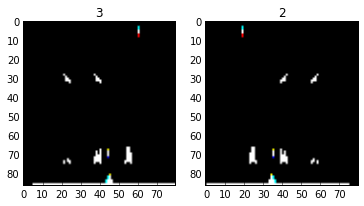

In [102]:
imgInd = 4999
print(h1.shape)
plt.subplot(1,2,1)
plt.imshow(swapaxes(X[imgInd]))
plt.title(np.argmax(pred[imgInd]))
plt.subplot(1,2,2)
plt.imshow(swapaxes(X[imgInd,:,:,::-1]))
plt.title(np.argmax(get_output(X[imgInd,:,:,::-1].reshape(1,3,86,80))))
plt.show()

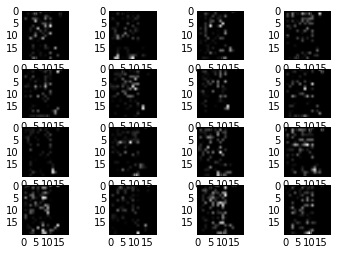

In [103]:
for hInd in range(h1.shape[1]):
    plt.subplot(4,4,hInd+1)
    plt.imshow(h1[imgInd, hInd], cmap=plt.cm.gray)
plt.show()

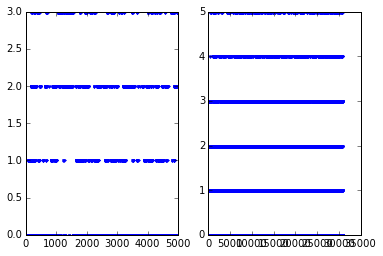

In [104]:
plt.subplot(1,2,1)
plt.plot(np.argmax(pred, axis=1),'.')
plt.subplot(1,2,2)
plt.plot(np.where(Y>0)[1],'.')

In [105]:
print(pred.shape)
pred

(5000, 6)


array([[ 0.28425238, -0.89200872, -0.49563628, -0.94915164, -1.02867663,
        -1.07229686],
       [ 0.26446283, -0.93931782, -0.42351407, -0.96693063, -1.04643166,
        -1.09006238],
       [ 0.26446283, -0.93931782, -0.42351407, -0.96693063, -1.04643166,
        -1.09006238],
       ..., 
       [-1.04782093, -1.17396855, -1.10017395,  0.75071597, -0.99455005,
        -0.71845227],
       [-1.1718632 , -1.19179177, -0.771034  ,  0.51032794, -0.93246394,
        -0.77288938],
       [-1.23256981, -1.24609613, -1.01152754,  0.82237804, -0.98693115,
        -0.71829396]], dtype=float32)

In [106]:
np.sum(np.argmax(pred, axis=1) == np.argmax(Y[0:5000], axis=1))/pred.shape[0]

0.68679999999999997

In [107]:
with open('spccnn.pkl','wb') as outFile:
    pickle.dump(lasagne.layers.get_all_param_values(l_out), outFile)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(3000, whiten=True)
unravelX = X.reshape(X.shape[0], -1)
pca.fit(unravelX)

In [ ]:
pcaX = pca.transform(unravelX)
print(pcaX.shape)

In [ ]:
untransformX = pca.inverse_transform(pcaX)
print(untransformX.shape)

In [80]:
unX = untransformX.reshape(3829, 3, 86, 80)
unX = np.swapaxes(np.swapaxes(unX,1,3),1,2)
print(unX.shape)

(3829, 86, 80, 3)


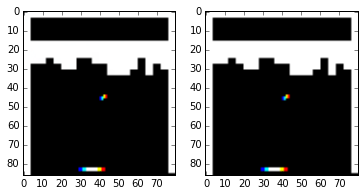

In [89]:
imgInd = 1402
plt.subplot(1,2,1)
plt.imshow(unX[imgInd])
plt.subplot(1,2,2)
plt.imshow(np.swapaxes(np.swapaxes(X[imgInd],0,2),0,1,))